Image shape:  (400, 400)
max:  66


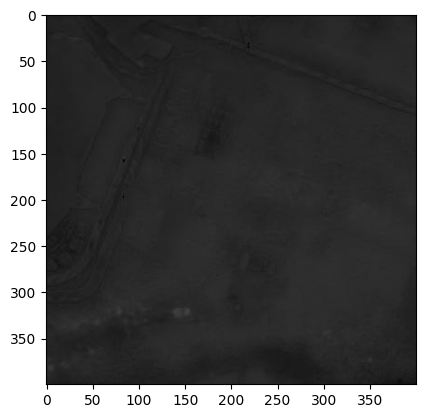

In [63]:
# import required library
import cv2
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np

# img: the image that is outputted from the downscaling model.
# cv2.imread reads the image stated above as a numpy array.
# Successful importing is shown by the shape statement (should be 400 by 400 based on GDAL statement)
# gdal_translate -of JPEG -outsize 400 400 "PATH_TO_OUTPUTTED_TIF.tif" "PATH_TO_SAVE.png"
img = cv2.imread("C:/Users/reece/OneDrive - University of Bristol/RP3/Code/Thermal/final/Downscaled_LST_usingS2_10m_16_04_2023.png",0)
print('Image shape: ',img.shape)

# The maximum temperature of the image which is caused by the presence of fires/abnomalities
max = np.amax(img)
print('max: ',max)

# Visualise the image. This is greyscale since GDAL imports the single band radiance measurements from the TIF file.
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

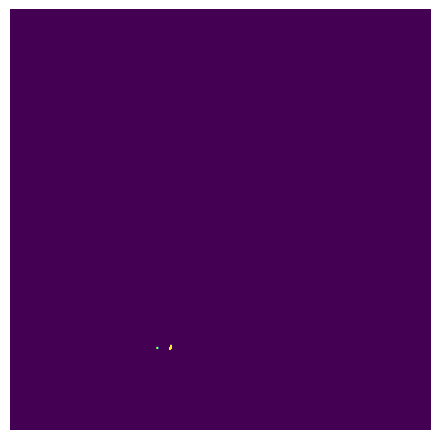

In [64]:
# import required libraries
import cv2
from matplotlib import pyplot as plt
import numpy as np

# Thresholding the pixels based on the 95th percentile of the maximum temperature of the image.
th, testimg_thresh = cv2.threshold(img, max*0.95, 1, cv2.THRESH_BINARY)

# Visualise the thresholded image
fig, ax = plt.subplots()
plt.tight_layout() 
plt.axis("off")
ax.imshow(testimg_thresh)

# Normalise the image to a range of 0 to 1.0 based on the minimum and maximum values of the image.
img_normalized = cv2.normalize(testimg_thresh.copy(), None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
img_normalized_95 = img_normalized.copy()


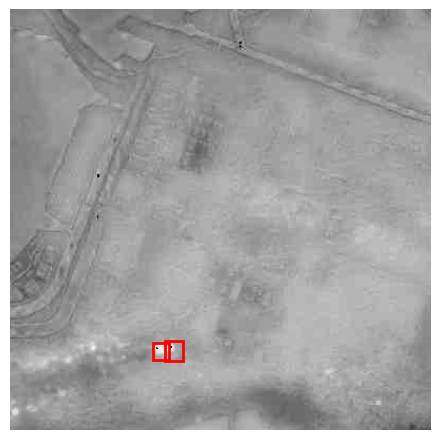

In [68]:
# In order to increase the size of the remaining pixels (indicated by 1s after thresholding), we use dilation.
# A kernel of 10 by 10 is used to increase the size of the pixels.
kernel = np.ones((10,10), np.uint8)
dilated_img = cv2.dilate(testimg_thresh, kernel, iterations=1)
output_img = dilated_img.copy()

# Find the contours of the image. This is done by finding the edges of the pixels and then drawing a bounding box around them.
# This section of code is based on the examples provided by opencv documentation., https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html
contours, hier = cv2.findContours(dilated_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
rectangle_coords = []
cv2rect = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(output_img, (x, y), (x + w, y + h), 255, 5)
    rectangle_coords.append([x,y,w,h])

# Plot the bounding boxes around the edges of the pixels and overlay this on the original image for context.
fig, ax = plt.subplots()
plt.tight_layout() 
plt.axis("off")
# Purely for visualisation purposes, pixel values have been brightened by a scale factor of 4. Max pixel now being max*4
img_convert = img.copy()
img_convert = img_convert * 4
ax.imshow(cv2.cvtColor(img_convert, cv2.COLOR_BGR2RGB))
for i in range(len(rectangle_coords)):
    rect = patches.Rectangle((rectangle_coords[i][0], rectangle_coords[i][1]), rectangle_coords[i][2]+5, rectangle_coords[i][3]+5, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)



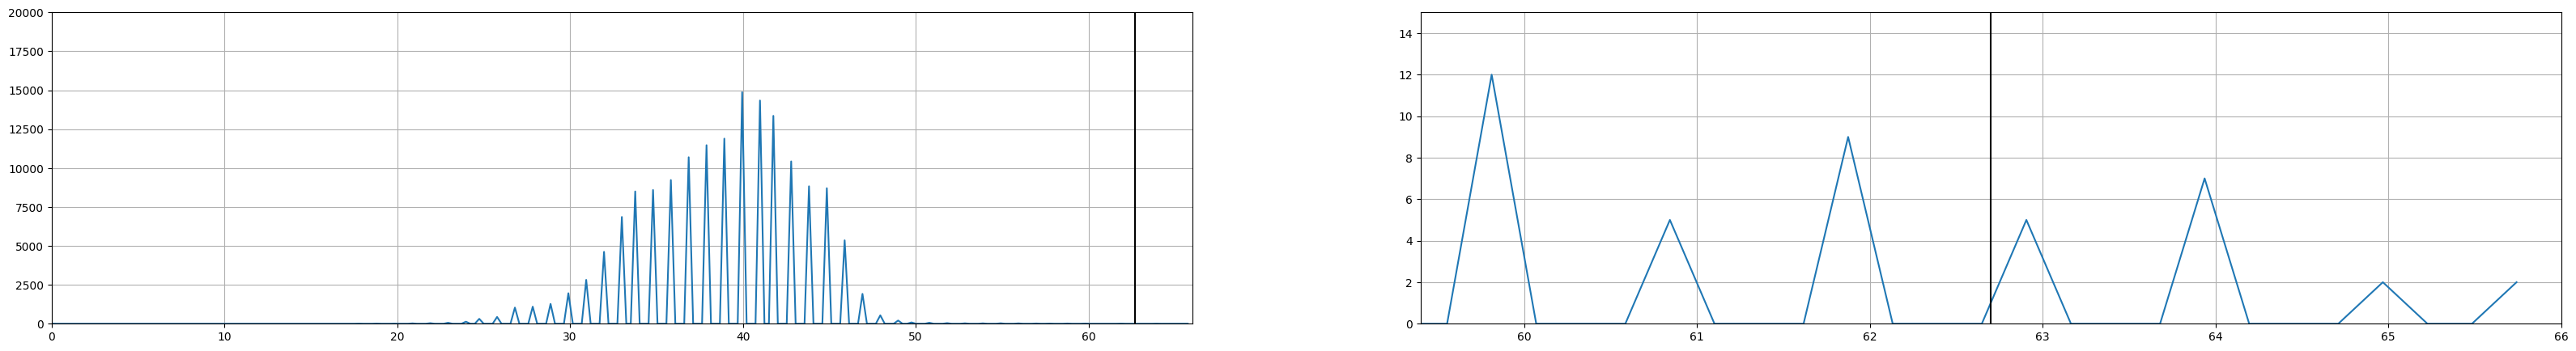

In [71]:
# Numpy provides a histogram function which can be used
histogram, bin_edges = np.histogram(img, bins=256, range=(0, max))

# Visualising the histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (40, 5))

# Limits set at the maximum temperature of the image
ax1.set_xlim([0.0, max])
ax1.set_ylim([0, 20000])
ax1.plot(bin_edges[0:-1], histogram)
ax1.grid(True)
ax1.vlines(x=max*0.95, ymin=0.0, ymax=20000, color='k')


# Zoomed in figure of the thresholded values set at 95th percentile of the maximum temperature of the image.
ax2.plot(bin_edges[0:-1], histogram) 
ax2.set_xlim([max*0.90, max])
ax2.set_ylim([0,15])
ax2.grid(True)
ax2.vlines(x=max*0.95, ymin=0.0, ymax=15, color='k')


plt.savefig('histograms.svg')
plt.show()


